In [1]:
#!pip install nltk
#!pip install pyLDAvis

In [2]:
import nltk; 
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ricki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [4]:
df = pd.read_csv("data/CNN_test.csv")
print("n° de noticias: ",len(df))
df.head()

n° de noticias:  8534


,text,label
0,El Tribunal Constitucional (TC) resolvió este ...,política y conflictos
1,El 25° Juzgado Civil de Santiago condenó al fi...,catástrofes y accidentes
2,Desde su creación en la ciudad de Valparaíso e...,cultura y arte
3,Un escándalo. El volante marfileño Yaya Touré ...,cultura y arte
4,Durante la versión más reciente de “War Table”...,política y conflictos


In [5]:
df["text"][0]

'El Tribunal Constitucional (TC) resolvió este jueves acoger el requerimiento presentado por parlamentarios de Chile Vamos en contra del proyecto que sanciona el negacionismo de los crímenes y violaciones a los derechos humanos durante la dictadura en Chile. De acuerdo a la resolución, la instancia fue respaldada por 9 votos contra 1 por el pleno del TC, declarando inconstitucional el artículo que refiere al concepto de negacionismo. Asimismo, la mayoría del tribunal advirtió TC debió ser aprobado por quórum calificado y no simple al ser una ley que toca el concepto de libertad de expresión, según informó La Tercera. Bellolio y críticas por designación de Delgado: "No sean picados, pongan por delante el diálogo"Leer más Camila Flores, diputada de Renovación Nacional, valoró el resultado, enfatizando que el proyecto "atenta contra libertad de expresión, de cátedra y conciencia, no cumpliendo con estándares internacionales en la materia". "Estamos muy contentos porque se esgrimieron los 

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
data = df.text.values.tolist()
data[0]

'El Tribunal Constitucional (TC) resolvió este jueves acoger el requerimiento presentado por parlamentarios de Chile Vamos en contra del proyecto que sanciona el negacionismo de los crímenes y violaciones a los derechos humanos durante la dictadura en Chile. De acuerdo a la resolución, la instancia fue respaldada por 9 votos contra 1 por el pleno del TC, declarando inconstitucional el artículo que refiere al concepto de negacionismo. Asimismo, la mayoría del tribunal advirtió TC debió ser aprobado por quórum calificado y no simple al ser una ley que toca el concepto de libertad de expresión, según informó La Tercera. Bellolio y críticas por designación de Delgado: "No sean picados, pongan por delante el diálogo"Leer más Camila Flores, diputada de Renovación Nacional, valoró el resultado, enfatizando que el proyecto "atenta contra libertad de expresión, de cátedra y conciencia, no cumpliendo con estándares internacionales en la materia". "Estamos muy contentos porque se esgrimieron los 

In [7]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[0]

'El Tribunal Constitucional (TC) resolvió este jueves acoger el requerimiento presentado por parlamentarios de Chile Vamos en contra del proyecto que sanciona el negacionismo de los crímenes y violaciones a los derechos humanos durante la dictadura en Chile. De acuerdo a la resolución, la instancia fue respaldada por 9 votos contra 1 por el pleno del TC, declarando inconstitucional el artículo que refiere al concepto de negacionismo. Asimismo, la mayoría del tribunal advirtió TC debió ser aprobado por quórum calificado y no simple al ser una ley que toca el concepto de libertad de expresión, según informó La Tercera. Bellolio y críticas por designación de Delgado: "No sean picados, pongan por delante el diálogo"Leer más Camila Flores, diputada de Renovación Nacional, valoró el resultado, enfatizando que el proyecto "atenta contra libertad de expresión, de cátedra y conciencia, no cumpliendo con estándares internacionales en la materia". "Estamos muy contentos porque se esgrimieron los 

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))
print(data_words[0])

['el', 'tribunal', 'constitucional', 'tc', 'resolvio', 'este', 'jueves', 'acoger', 'el', 'requerimiento', 'presentado', 'por', 'parlamentarios', 'de', 'chile', 'vamos', 'en', 'contra', 'del', 'proyecto', 'que', 'sanciona', 'el', 'negacionismo', 'de', 'los', 'crimenes', 'violaciones', 'los', 'derechos', 'humanos', 'durante', 'la', 'dictadura', 'en', 'chile', 'de', 'acuerdo', 'la', 'resolucion', 'la', 'instancia', 'fue', 'respaldada', 'por', 'votos', 'contra', 'por', 'el', 'pleno', 'del', 'tc', 'declarando', 'el', 'articulo', 'que', 'refiere', 'al', 'concepto', 'de', 'negacionismo', 'asimismo', 'la', 'mayoria', 'del', 'tribunal', 'advirtio', 'tc', 'debio', 'ser', 'aprobado', 'por', 'quorum', 'calificado', 'no', 'simple', 'al', 'ser', 'una', 'ley', 'que', 'toca', 'el', 'concepto', 'de', 'libertad', 'de', 'expresion', 'segun', 'informo', 'la', 'tercera', 'bellolio', 'criticas', 'por', 'designacion', 'de', 'delgado', 'no', 'sean', 'picados', 'pongan', 'por', 'delante', 'el', 'dialogo', 'lee

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[16]]])

['un', 'hombre', 'de', 'anos', 'fallecio', 'durante', 'esta', 'jornada', 'tras', 'recibir', 'el', 'impacto', 'de', 'una', 'piedra', 'mientras', 'circulaba', 'como', 'copiloto', 'de', 'un', 'vehiculo', 'menor', 'en', 'chimbarongo', 'region', 'de', 'higgins', 'el', 'accidente', 'tuvo', 'lugar', 'en', 'el', 'sector', 'de', 'tinguiririca', 'donde', 'por', 'causas', 'que', 'aun', 'se', 'investigan', 'se', 'desprendio', 'este', 'elemento', 'desde', 'un', 'camion', 'de', 'aridos', 'que', 'cayo', 'sobre', 'el', 'vehiculo', 'segun', 'se', 'indico', 'el', 'camion', 'involucrado', 'fue', 'buscado', 'por', 'personal', 'policial', 'para', 'tomar', 'la', 'declaracion', 'del', 'conductor', 'de', 'este', 'vehiculo', 'lo', 'cual', 'ya', 'habria', 'sido', 'logrado', 'en', 'el', 'lugar', 'se', 'presento', 'personal', 'de', 'la', 'siat', 'de', 'carabineros', 'quienes', 'desarrollaran', 'diligencias', 'investigan', 'para', 'descubrir', 'como', 'se', 'llevaron_cabo', 'los', 'hechos', 'fiscalia', 'ohiggins',

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
#!python -m spacy download es_core_news_md

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('es_core_news_md')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [16]:
print(data_lemmatized[1])

['condeno', 'fisco', 'pagar', 'indemnizacion', 'millón', 'familia', 'interno', 'fallecido', 'colina_ii', 'incendio', 'ocurrido', 'abril', 'ano', 'acuerdo', 'sentencia', 'magistrado', 'susana', 'rodriguez', 'munoz', 'acogio', 'parcialmente', 'demanda', 'entablado', 'establecer', 'responsabilidad', 'faltar', 'gendarmerio', 'decir', 'resolucion', 'acredito', 'partir', 'gendarmerio', 'causado', 'actuacion', 'funcionario', 'ajusto', 'hecho', 'atender', 'velar', 'vida', 'integridad', 'interno', 'camara', 'grabar', 'sujeto', 'ex', 'pareja', 'abdomen', 'huir', 'dejar él', 'fallo', 'sostener', 'sumario_administrativo', 'destinado', 'sismo', 'grado', 'tarde', 'región', 'tarapaca_antofagasta', 'atacama', 'segun', 'centro_sismologico', 'nacional', 'temblor', 'producir', 'hora', 'epicentro', 'sureste', 'localidad', 'precordillerán', 'socaire', 'provocar', 'algun_grado', 'alarmar', 'habitante', 'zona', 'norte', 'tarde', 'sintio', 'sismo', 'menor_intensidad', 'kilometro', 'lugar', 'antofagasta', 'eme

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word

In [18]:
id2word[0]

'acoger'

In [19]:
# Create Corpus
texts = data_lemmatized

In [20]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 5), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 5), (56, 1), (57, 1), (58, 1), (59, 3), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 6), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 3), (88, 2), (89, 1)]]


In [21]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acoger', 2),
  ('actuar', 1),
  ('agrego', 1),
  ('alterar', 1),
  ('apoyar', 1),
  ('aprobar', 1),
  ('argumento', 1),
  ('articulo', 1),
  ('artimana', 1),
  ('aseverar', 1),
  ('asimismo', 1),
  ('atentado', 1),
  ('atentar', 1),
  ('bellolio', 1),
  ('buscar', 1),
  ('complemento', 1),
  ('concepto', 2),
  ('conciencia', 1),
  ('congresista', 1),
  ('consignar', 1),
  ('contento', 1),
  ('crimen', 1),
  ('critica', 1),
  ('critico_duramente', 1),
  ('cuarto', 1),
  ('cumplir', 1),
  ('declarar', 3),
  ('delante', 1),
  ('delgado', 1),
  ('demostrar', 1),
  ('dialogo', 1),
  ('dictaduro', 2),
  ('diferente', 1),
  ('diputada', 1),
  ('diputado', 1),
  ('ejecutados_politicos', 1),
  ('enfatizar', 1),
  ('esgrimir', 1),
  ('estandares_internacional', 1),
  ('exiliado', 1),
  ('expresion', 5),
  ('firmado', 1),
  ('flor', 2),
  ('fondo', 1),
  ('forma', 1),
  ('grave', 1),
  ('hecho', 1),
  ('historico', 1),
  ('informo', 1),
  ('instancia', 2),
  ('ir', 1),
  ('jueves', 1),
  ('le

In [22]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics(num_words=25))

[(0,
  '0.048*"incendio" + 0.030*"fuego" + 0.029*"lugar" + 0.029*"vehiculo" + '
  '0.028*"accidente" + 0.027*"bombero" + 0.026*"sector" + 0.017*"ruta" + '
  '0.017*"emergencia" + 0.017*"vivienda" + 0.015*"conductor" + 0.015*"dejar" + '
  '0.015*"siniestro" + 0.014*"trabajar" + 0.013*"transito" + '
  '0.013*"pic_twitter" + 0.012*"calle" + 0.012*"kilometro" + 0.011*"causa" + '
  '0.011*"lesionado" + 0.010*"muerto" + 0.010*"fallecido" + 0.010*"noche" + '
  '0.009*"momento" + 0.009*"personal"'),
 (1,
  '0.048*"llama" + 0.033*"millon" + 0.030*"obra" + 0.023*"cuerpo" + '
  '0.022*"cabeza" + 0.022*"empate" + 0.021*"facil" + 0.020*"doble" + '
  '0.019*"combate" + 0.018*"museo" + 0.018*"incendio_forestal" + '
  '0.017*"protegido" + 0.017*"controlar" + 0.016*"opción" + 0.016*"alarma" + '
  '0.016*"continuidad" + 0.014*"recoleta" + 0.014*"anade" + 0.013*"cine" + '
  '0.013*"efectividad" + 0.012*"plano" + 0.012*"euros" + 0.011*"camioneta" + '
  '0.011*"combatir" + 0.010*"comandante"'),
 (2,
  '0.0

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ricki/miniconda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.252342  0.054601       1        1  21.046170
2     -0.270284 -0.070828       2        1  15.404400
14    -0.214798 -0.017055       3        1  13.035022
6     -0.242006  0.088919       4        1  12.464055
12    -0.155227 -0.291835       5        1   7.635221
9     -0.181315  0.037683       6        1   6.730291
17    -0.127259  0.112792       7        1   3.456879
3     -0.054810  0.111000       8        1   3.331563
5     -0.006642  0.143476       9        1   3.215537
15    -0.019353  0.041956      10        1   2.825412
0     -0.034416 -0.264117      11        1   2.526098
18     0.031168  0.104358      12        1   2.106626
16     0.018199  0.114647      13        1   2.098575
7      0.042252 -0.106703      14        1   1.949051
1      0.210534 -0.026423      15        1   0.694339
11     0.225083  0.000328      16        1   0.609614
13     0.242953 -0.020719      17        1   0.245618
19     0.261052 -0.004282      18        1   0.243826
4      0.260446 -0.003960      19        1   0.243186
10     0.266764 -0.003839      20        1   0.138516, topic_info=               Term         Freq        Total Category  logprob  loglift
406            caso  7688.000000  7688.000000  Default  30.0000  30.0000
362           nuevo  7827.000000  7827.000000  Default  29.0000  29.0000
2057         vacuna  3615.000000  3615.000000  Default  28.0000  28.0000
102             ano  9970.000000  9970.000000  Default  27.0000  27.0000
460      presidente  3510.000000  3510.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
6129          hielo     0.025177     1.093791  Topic20 -11.1123   2.8105
9598         cumbre     0.025177     1.093788  Topic20 -11.1123   2.8105
6225          pacto     0.025177     1.093812  Topic20 -11.1123   2.8105
5691  originalmente     0.025177     1.093793  Topic20 -11.1123   2.8105
8526        apruebo     0.025177     1.093814  Topic20 -11.1123   2.8104

[1022 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
984       3  0.308589     abogado
984      14  0.690872     abogado
4644     19  0.969281    abordado
1526      9  0.995835  abstención
3112      3  0.996563       abuso
...     ...       ...         ...
89        4  0.329127        voto
89       13  0.670075        voto
210       2  0.989264          xa
210       3  0.008510          xa
211       2  0.999551        zona

[1756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 15, 7, 13, 10, 18, 4, 6, 16, 1, 19, 17, 8, 2, 12, 14, 20, 5, 11])

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.00100573618902

Coherence Score:  0.507223055108525


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=5)


2
7
12
17
22
27


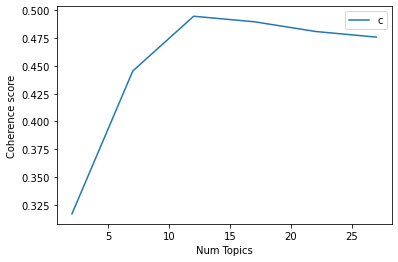

In [28]:
# Show graph
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3169
Num Topics = 7  has Coherence Value of 0.4454
Num Topics = 12  has Coherence Value of 0.4947
Num Topics = 17  has Coherence Value of 0.4897
Num Topics = 22  has Coherence Value of 0.481
Num Topics = 27  has Coherence Value of 0.4759


In [30]:
# Select the model and print the topics
optimal_model = model_list[3]
#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))



In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis


/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ricki/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ricki/miniconda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.262695 -0.033675       1        1  20.693697
6     -0.256916  0.002700       2        1  18.395414
2     -0.265542  0.014604       3        1  13.414251
14    -0.221619  0.080989       4        1  12.824058
12    -0.173721  0.264860       5        1  10.024830
3     -0.162179 -0.149588       6        1   6.071690
9     -0.177797 -0.066898       7        1   5.728006
15    -0.073083 -0.196729       8        1   3.757991
16     0.052243 -0.119424       9        1   2.097151
7      0.117140  0.191478      10        1   1.982224
1      0.083337  0.086034      11        1   1.677270
11     0.176630 -0.068889      12        1   0.965048
0      0.216548  0.037209      13        1   0.612388
5      0.231848 -0.008214      14        1   0.576516
4      0.228250 -0.013578      15        1   0.519321
13     0.239752 -0.010126      16        1   0.331242
10     0.247806 -0.010753      17        1   0.328904, topic_info=          Term          Freq         Total Category  logprob  loglift
406       caso   7530.000000   7530.000000  Default  30.0000  30.0000
2057    vacuna   3871.000000   3871.000000  Default  29.0000  29.0000
362      nuevo   7928.000000   7928.000000  Default  28.0000  28.0000
68    proyecto   3579.000000   3579.000000  Default  27.0000  27.0000
102        ano  10071.000000  10071.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
4637  jubilado     19.863615     20.917304  Topic17  -5.3064   5.6655
2752  atrapado     19.243020     20.296709  Topic17  -5.3381   5.6638
1484  culminar     18.151772     19.205460  Topic17  -5.3965   5.6607
3714   elector     36.671069    129.693826  Topic17  -4.6933   4.4540
2155    ver él     25.473177    152.453481  Topic17  -5.0576   3.9279

[864 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
984      11  0.998019  abogado
91        1  0.220945    abril
91        2  0.128999    abril
91        4  0.068616    abril
91        6  0.164679    abril
...     ...       ...      ...
89        2  0.266850     voto
89        9  0.732095     voto
210       4  0.998869       xa
211       4  0.973347     zona
211       7  0.026531     zona

[1450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 3, 15, 13, 4, 10, 16, 17, 8, 2, 12, 1, 6, 5, 14, 11])

In [32]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/tmp/ipykernel_22886/591139066.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_22886/591139066.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.5808,"decir, ministro, presidente, hacer, diputado, ...","[tribunal_constitucional, resolver, jueves, ac..."
1,1,14,0.4269,"hora, lugar, persona, zona, comuna, sector, en...","[condeno, fisco, pagar, indemnizacion, millón,..."
2,2,3,0.2716,"proyecto, empresa, retiro, millón, fondo, mes,...","[error, buscado_acercar, amplio, publico, obra..."
3,3,14,0.4770,"hora, lugar, persona, zona, comuna, sector, en...","[escandalo, volante, marfileno, expulsado, par..."
4,4,8,0.7065,"ano, mas, hacer, nuevo, primero, decir, ver, s...","[version, reciente, table, presentacion, enfoc..."
5,5,6,0.3723,"decir, ministro, presidente, hacer, diputado, ...","[pleno, tribunal_constitucional, resolver, adm..."
6,6,3,0.3230,"proyecto, empresa, retiro, millón, fondo, mes,...","[incendios_forestal, desatado, ultimo, tiempo,..."
7,7,2,0.2901,"persona, salud, medida, mas, mayor, caso, pand...","[serie, diligencia, realizar, viernes, colegio..."
8,8,6,0.3391,"decir, ministro, presidente, hacer, diputado, ...","[estudio, revelo, mujer, calificar, nota, infe..."
9,9,8,0.4400,"ano, mas, hacer, nuevo, primero, decir, ver, s...","[ministro, defensa, mario_desbord, comunico, b..."


In [33]:
pd.options.display.max_colwidth = 1000

print(df_dominant_topic[:10]["Text"])

0    [tribunal_constitucional, resolver, jueves, acoger, requerimiento_presentado, parlamentario, ir, proyecto, sancionar, negacionismo, crimen, violación, resolucion, instancia, respaldado, voto, pleno, declarar, articulo, referir, concepto, asimismo, aprobar, quorum_calificado, simple, ley, tocar, concepto, libertad, informo, bellolio, critica, delgado, picado, poner, delante, dialogo, leer, mas, diputada, renovacion_nacional, valoro, resultado, enfatizar, proyecto, atentar, libertad, expresion, conciencia, cumplir, estandares_internacional, materia, contento, esgrimir, argumento, forma, fondo, agrego, congresista, diputado, partido_socialistar, critico_duramente, resolucion, aseverar, demostrar, actuar, cuarto, uso, diferente, artimana, acoger, recurso, complemento, instancia, buscar, alterar, libertad, expresion, sancionar, querer, negar, hecho, historico, grave, negar, tortura, atentado, expresion, ejecutados_politicos, exiliado, manifesto, consignar, recurso, legal, apoyar, firma